In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import warnings
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
def load_unit_data(unit, folder):
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    return pd.read_csv("../data/processed/{}/unit{}_rms_anomaly_excluded.csv".format(folder, unit_name), index_col=0)

def load_all_data():
    units = range(0, 20)
    df_all = pd.DataFrame()
    for idx, unit in enumerate(units):
        file_name = "../data/processed/train/unit{}_rms_more_features.csv".format("000{}".format(unit) if unit < 10 else "00{}".format(unit))
        file_df = pd.read_csv(file_name, index_col=0)
        file_df['timestamp'] = pd.to_datetime(file_df['timestamp'])
        df_all = df_all.append(file_df)
    return df_all
    

prepare feature: time remaining until failure

In [19]:
def prepare_features(folder='train'):
    unit_range = range(0, 20) if folder == 'train' else range(20, 50)
    for unit in unit_range:
        df_unit = load_unit_data(unit, folder)
        df_unit['timestamp'] = pd.to_datetime(df_unit['timestamp'])
        dt_max = df_unit['timestamp'].max()
        unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
        time_diffs, warnings_til_now, errors_til_now = [], [], []
        df_alarm = pd.read_csv("../data/raw/{}/unit{}_alarms.csv".format(folder, unit_name), header=None, names=['timestamp', 'warning'])
        df_alarm['timestamp'] = pd.to_datetime(df_alarm['timestamp'])
        for idx, row in df_unit.iterrows():
            # time diff in days until failure
            time_diff = dt_max - row['timestamp']
            time_diffs.append(divmod(time_diff.total_seconds(), 60)[0] / (60 * 24))

            # num of accumulated warnings/errors before current observation
            df_before = df_alarm[(df_alarm['timestamp'] < row['timestamp'])]
            accum_warnings = len(df_before[df_before['warning'] == 'warning'].index)
            accum_errors = len(df_before[df_before['warning'] == 'error'].index)
            warnings_til_now.append(accum_warnings)
            errors_til_now.append(accum_errors)

        df_unit['hours_to_failure'] = time_diffs
        df_unit['accumulated_warnings'] = warnings_til_now
        df_unit['accumulated_errors'] = errors_til_now
        df_unit.to_csv("../data/processed/{}/unit{}_rms_more_features.csv".format(folder, unit_name))
    print("Done")

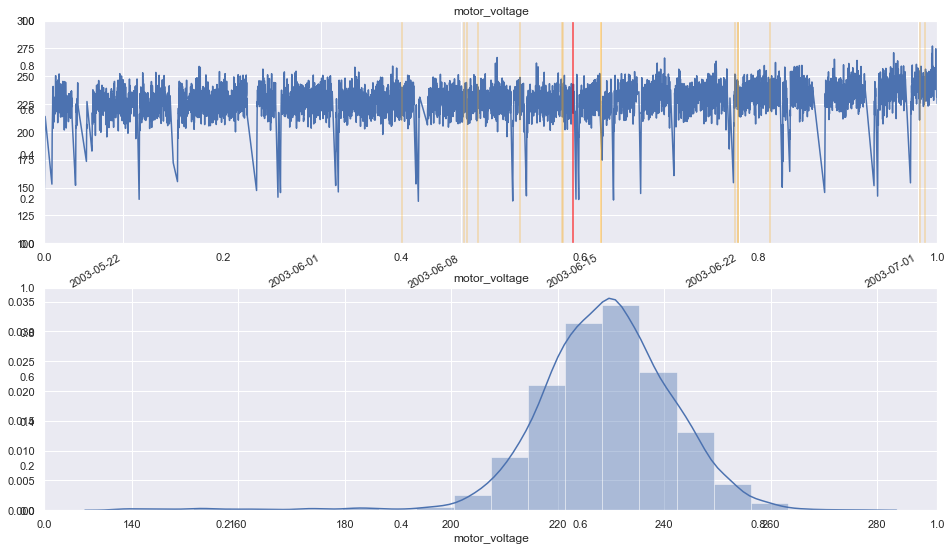

In [42]:
def plot_feature_in_df(unit, feature_name, ylim_low=-20, ylim_high=3000, bins=20):
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    df_unit = pd.read_csv("../data/processed/train/unit{}_rms_anomaly_excluded.csv".format(unit_name), index_col=0)
    df_unit['timestamp'] = pd.to_datetime(df_unit['timestamp'])
    sns.set()
    fig, axs = plt.subplots(2, 1, figsize=(16, 10))
    ax1 = fig.add_subplot(211)
    ax1.title.set_text(feature_name)
    df_unit.set_index('timestamp', inplace=True)
    if ylim_low is None and ylim_high is None:
        df_unit[feature_name].plot(label=feature_name)
    else:
        df_unit[feature_name].plot(ylim=(ylim_low, ylim_high), label=feature_name)
        
    # plot warnings and errors
    df_alarm = pd.read_csv("../data/raw/train/unit{}_alarms.csv".format(unit_name), header=None, names=['timestamp', 'warning'])
    df_alarm['timestamp'] = pd.to_datetime(df_alarm['timestamp'])
    df_alarm.set_index('timestamp', inplace=True)
    warning_x = df_alarm[df_alarm['warning'] == 'warning'].index.values
    error_x = df_alarm[df_alarm['warning'] == 'error'].index.values
    for warning in warning_x:
        plt.axvline(x=warning, color='orange', alpha=0.3, label='warning')
    for error in error_x:
        plt.axvline(x=error, color='red', alpha=0.7, label='error')
    #plt.legend()
    ax2 = fig.add_subplot(212)
    sns.distplot(df_unit[feature_name], bins=bins)
    ax2.title.set_text(feature_name)
    plt.show()
plot_feature_in_df(15, 'motor_voltage', ylim_low=100, ylim_high=300)

In [3]:
df_all = load_all_data()
df_all

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,hours_to_failure,accumulated_warnings,accumulated_errors
53,2003-12-14 04:45:12.721247385,956.579922,217.484012,25.042943,63.002208,34.350839,636.535417,0,0
54,2003-12-14 04:55:40.840586778,1063.856934,206.792646,28.782024,69.830473,28.464714,636.528472,0,0
55,2003-12-14 05:05:37.291038943,1005.212018,219.900341,29.302032,68.019838,39.165607,636.521528,0,0
56,2003-12-14 05:17:06.465193131,1115.011284,220.373208,30.767473,79.283341,32.983723,636.513194,0,0
57,2003-12-14 05:25:31.807130176,1028.243351,194.055713,28.676094,75.055177,37.553089,636.507639,0,0
...,...,...,...,...,...,...,...,...,...
24341,2005-04-11 18:16:25.989419843,1042.179737,307.539123,47.975455,218.791347,100.807647,0.027778,53,1
24342,2005-04-11 18:26:55.689073846,1069.597134,297.454082,47.263750,218.882763,109.359761,0.020139,53,1
24343,2005-04-11 18:35:25.402556965,1116.392388,316.277175,50.395914,218.935540,102.472228,0.014583,53,1
24344,2005-04-11 18:45:44.900113142,1122.974015,320.776152,49.165122,225.527057,103.086940,0.006944,53,1


In [4]:
df_all_features = df_all[df_all.columns[1:]]
df_all
num_pipeline = Pipeline([('std_scaler', StandardScaler())])

Y_LABEL = 'days_to_failure'
train_set, test_set = train_test_split(df_all_features, test_size=0.2, random_state=42)
x_train = num_pipeline.fit_transform(train_set.drop(columns=[Y_LABEL], axis=1))
x_test = num_pipeline.fit_transform(test_set.drop(columns=[Y_LABEL], axis=1))
y_train, y_test = num_pipeline.fit_transform(train_set[[Y_LABEL]]), num_pipeline.fit_transform(test_set[[Y_LABEL]])

In [6]:
def save_keras_model(model, history, file_name):
    model_json = model.to_json()
    with open("../models/failure_predicting/{}.json".format(file_name), 'w') as json_file:
        json_file.write(model_json)
    model.save_weights("../models/failure_predicting/{}.h5".format(file_name))
    with open('../models/failure_predicting/{}.history'.format(file_name), 'wb') as file_history:
        pickle.dump(history.history, file_history)
    print("model saved")
    
def load_nn_model(model_name):
    with open('../models/failure_predicting/{}.json'.format(model_name)) as f:
        nn_model = model_from_json(f.read())
    nn_model.load_weights('../models/failure_predicting/{}.h5'.format(model_name))
    return nn_model

Keras model constructed
Train on 668903 samples, validate on 167226 samples
Epoch 1/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.5295 - coeff_determination: 0.4428 - val_loss: 0.5271 - val_coeff_determination: 0.4443
Epoch 2/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.4693 - coeff_determination: 0.5088 - val_loss: 0.4660 - val_coeff_determination: 0.5096
Epoch 3/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.4575 - coeff_determination: 0.5205 - val_loss: 0.4765 - val_coeff_determination: 0.5023
Epoch 4/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.4506 - coeff_determination: 0.5289 - val_loss: 0.4603 - val_coeff_determination: 0.5201
Epoch 5/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.4446 - coeff_determination: 0.5344 - val_loss: 0.4557 - val_coeff_determination: 0.5205
Epoch 6/1000
668903/668903 [==========================

668903/668903 [==============================] - 45s 68us/step - loss: 0.4053 - coeff_determination: 0.5750 - val_loss: 0.3963 - val_coeff_determination: 0.5860
Epoch 48/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.4050 - coeff_determination: 0.5750 - val_loss: 0.4036 - val_coeff_determination: 0.5796
Epoch 49/1000
668903/668903 [==============================] - 46s 68us/step - loss: 0.4042 - coeff_determination: 0.5755 - val_loss: 0.4283 - val_coeff_determination: 0.5481
Epoch 50/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.4040 - coeff_determination: 0.5761 - val_loss: 0.4030 - val_coeff_determination: 0.5766
Epoch 51/1000
668903/668903 [==============================] - 49s 73us/step - loss: 0.4039 - coeff_determination: 0.5760 - val_loss: 0.4534 - val_coeff_determination: 0.5200
Epoch 52/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.4036 - coeff_determination: 0.5762 - val_loss: 0.440

Epoch 94/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3947 - coeff_determination: 0.5840 - val_loss: 0.4260 - val_coeff_determination: 0.5434
Epoch 95/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3945 - coeff_determination: 0.5849 - val_loss: 0.3910 - val_coeff_determination: 0.5886
Epoch 96/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3943 - coeff_determination: 0.5845 - val_loss: 0.3921 - val_coeff_determination: 0.5801
Epoch 97/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3947 - coeff_determination: 0.5843 - val_loss: 0.5893 - val_coeff_determination: 0.3568
Epoch 98/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3944 - coeff_determination: 0.5847 - val_loss: 0.3798 - val_coeff_determination: 0.5992
Epoch 99/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3945 - coeff_determination: 0.5841 - v

668903/668903 [==============================] - 45s 68us/step - loss: 0.3961 - coeff_determination: 0.5832 - val_loss: 0.4278 - val_coeff_determination: 0.5391
Epoch 141/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3950 - coeff_determination: 0.5836 - val_loss: 0.3898 - val_coeff_determination: 0.5870
Epoch 142/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3959 - coeff_determination: 0.5832 - val_loss: 0.3723 - val_coeff_determination: 0.6086
Epoch 143/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3957 - coeff_determination: 0.5830 - val_loss: 0.4235 - val_coeff_determination: 0.5470
Epoch 144/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3951 - coeff_determination: 0.5832 - val_loss: 0.3938 - val_coeff_determination: 0.5801
Epoch 145/1000
668903/668903 [==============================] - 46s 68us/step - loss: 0.3953 - coeff_determination: 0.5834 - val_loss: 

668903/668903 [==============================] - 45s 68us/step - loss: 0.3926 - coeff_determination: 0.5859 - val_loss: 0.4076 - val_coeff_determination: 0.5610
Epoch 187/1000
668903/668903 [==============================] - 49s 73us/step - loss: 0.3933 - coeff_determination: 0.5845 - val_loss: 0.3948 - val_coeff_determination: 0.5842
Epoch 188/1000
668903/668903 [==============================] - 46s 68us/step - loss: 0.3934 - coeff_determination: 0.5852 - val_loss: 0.3804 - val_coeff_determination: 0.6009
Epoch 189/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3928 - coeff_determination: 0.5856 - val_loss: 0.4110 - val_coeff_determination: 0.5662
Epoch 190/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3926 - coeff_determination: 0.5868 - val_loss: 0.4391 - val_coeff_determination: 0.5241
Epoch 191/1000
668903/668903 [==============================] - 45s 68us/step - loss: 0.3924 - coeff_determination: 0.5861 - val_loss: 

668903/668903 [==============================] - 51s 76us/step - loss: 0.3906 - coeff_determination: 0.5883 - val_loss: 0.4034 - val_coeff_determination: 0.5715: 11s - loss: 0.3904 - - ETA: 10s - loss: 0.3903 - coe - ETA: 9s - loss: 0.3907 - coeff_determination: - ETA: 9s - loss: 0.3908 - coeff_determinat - ETA: 8s - loss: 0. - ETA: 6s - l - ETA: 4s - loss: 0.3910 - coeff_determinatio - ETA: 4s  - ETA: 1s - loss:
Epoch 232/1000
668903/668903 [==============================] - 52s 78us/step - loss: 0.3915 - coeff_determination: 0.5876 - val_loss: 0.3852 - val_coeff_determination: 0.595807 - coeff_deter - ETA: 6s - loss:  - ETA: 1s - loss: 0.3919 - coeff_deter - ETA: 0s - loss: 0.3919 - coeff_determi
Epoch 233/1000
668903/668903 [==============================] - 51s 76us/step - loss: 0.3912 - coeff_determination: 0.5873 - val_loss: 0.3875 - val_coeff_determination: 0.5863 - ETA: 
Epoch 234/1000
668903/668903 [==============================] - 52s 77us/step - loss: 0.3906 - coeff_determi

668903/668903 [==============================] - 47s 70us/step - loss: 0.3894 - coeff_determination: 0.5896 - val_loss: 0.4014 - val_coeff_determination: 0.5790
Epoch 264/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3895 - coeff_determination: 0.5894 - val_loss: 0.3815 - val_coeff_determination: 0.5946
Epoch 265/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3897 - coeff_determination: 0.5888 - val_loss: 0.4121 - val_coeff_determination: 0.5523
Epoch 266/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3902 - coeff_determination: 0.5884 - val_loss: 0.4606 - val_coeff_determination: 0.4960
Epoch 267/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3905 - coeff_determination: 0.5880 - val_loss: 0.4004 - val_coeff_determination: 0.5746
Epoch 268/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3908 - coeff_determination: 0.5875 - val_loss: 

668903/668903 [==============================] - 47s 70us/step - loss: 0.3912 - coeff_determination: 0.5876 - val_loss: 0.4016 - val_coeff_determination: 0.5767
Epoch 310/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3910 - coeff_determination: 0.5881 - val_loss: 0.4099 - val_coeff_determination: 0.5714
Epoch 311/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3910 - coeff_determination: 0.5882 - val_loss: 0.4013 - val_coeff_determination: 0.5718
Epoch 312/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3909 - coeff_determination: 0.5881 - val_loss: 0.4424 - val_coeff_determination: 0.5236
Epoch 313/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3909 - coeff_determination: 0.5878 - val_loss: 0.4416 - val_coeff_determination: 0.5275
Epoch 314/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3911 - coeff_determination: 0.5879 - val_loss: 

668903/668903 [==============================] - 44s 66us/step - loss: 0.3909 - coeff_determination: 0.5874 - val_loss: 0.4069 - val_coeff_determination: 0.5678
Epoch 356/1000
668903/668903 [==============================] - 44s 66us/step - loss: 0.3907 - coeff_determination: 0.5881 - val_loss: 0.4099 - val_coeff_determination: 0.5701
Epoch 357/1000
668903/668903 [==============================] - 44s 66us/step - loss: 0.3913 - coeff_determination: 0.5877 - val_loss: 0.4090 - val_coeff_determination: 0.5709
Epoch 358/1000
668903/668903 [==============================] - 44s 66us/step - loss: 0.3902 - coeff_determination: 0.5875 - val_loss: 0.4056 - val_coeff_determination: 0.5744
Epoch 359/1000
668903/668903 [==============================] - 44s 66us/step - loss: 0.3902 - coeff_determination: 0.5882 - val_loss: 0.4210 - val_coeff_determination: 0.5515
Epoch 360/1000
668903/668903 [==============================] - 44s 66us/step - loss: 0.3900 - coeff_determination: 0.5889 - val_loss: 

668903/668903 [==============================] - 46s 69us/step - loss: 0.3891 - coeff_determination: 0.5895 - val_loss: 0.4034 - val_coeff_determination: 0.5650
Epoch 402/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3893 - coeff_determination: 0.5888 - val_loss: 0.4306 - val_coeff_determination: 0.5441
Epoch 403/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3897 - coeff_determination: 0.5887 - val_loss: 0.3991 - val_coeff_determination: 0.5756
Epoch 404/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3890 - coeff_determination: 0.5902 - val_loss: 0.3752 - val_coeff_determination: 0.6072
Epoch 405/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3895 - coeff_determination: 0.5886 - val_loss: 0.4175 - val_coeff_determination: 0.5606
Epoch 406/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3894 - coeff_determination: 0.5900 - val_loss: 

668903/668903 [==============================] - 46s 68us/step - loss: 0.3898 - coeff_determination: 0.5890 - val_loss: 0.4120 - val_coeff_determination: 0.5573
Epoch 448/1000
668903/668903 [==============================] - 48s 71us/step - loss: 0.3886 - coeff_determination: 0.5897 - val_loss: 0.4350 - val_coeff_determination: 0.5389
Epoch 449/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3890 - coeff_determination: 0.5890 - val_loss: 0.3889 - val_coeff_determination: 0.5842
Epoch 450/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3887 - coeff_determination: 0.5896 - val_loss: 0.3814 - val_coeff_determination: 0.5992
Epoch 451/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3888 - coeff_determination: 0.5897 - val_loss: 0.3690 - val_coeff_determination: 0.6110
Epoch 452/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3894 - coeff_determination: 0.5889 - val_loss: 

668903/668903 [==============================] - 46s 69us/step - loss: 0.3878 - coeff_determination: 0.5903 - val_loss: 0.5114 - val_coeff_determination: 0.4436
Epoch 494/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3872 - coeff_determination: 0.5917 - val_loss: 0.4037 - val_coeff_determination: 0.5671
Epoch 495/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3876 - coeff_determination: 0.5913 - val_loss: 0.5677 - val_coeff_determination: 0.3747
Epoch 496/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3876 - coeff_determination: 0.5912 - val_loss: 0.4035 - val_coeff_determination: 0.5669
Epoch 497/1000
668903/668903 [==============================] - 47s 71us/step - loss: 0.3886 - coeff_determination: 0.5900 - val_loss: 0.4062 - val_coeff_determination: 0.5689
Epoch 498/1000
668903/668903 [==============================] - 47s 71us/step - loss: 0.3885 - coeff_determination: 0.5907 - val_loss: 

668903/668903 [==============================] - 46s 68us/step - loss: 0.3879 - coeff_determination: 0.5911 - val_loss: 0.4483 - val_coeff_determination: 0.5158
Epoch 540/1000
668903/668903 [==============================] - 47s 71us/step - loss: 0.3897 - coeff_determination: 0.5888 - val_loss: 0.4583 - val_coeff_determination: 0.5200
Epoch 541/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3874 - coeff_determination: 0.5918 - val_loss: 0.3741 - val_coeff_determination: 0.6096
Epoch 542/1000
668903/668903 [==============================] - 46s 68us/step - loss: 0.3879 - coeff_determination: 0.5908 - val_loss: 0.4174 - val_coeff_determination: 0.5662
Epoch 543/1000
668903/668903 [==============================] - 48s 72us/step - loss: 0.3880 - coeff_determination: 0.5914 - val_loss: 0.4488 - val_coeff_determination: 0.5219
Epoch 544/1000
668903/668903 [==============================] - 47s 71us/step - loss: 0.3880 - coeff_determination: 0.5905 - val_loss: 

668903/668903 [==============================] - 46s 69us/step - loss: 0.3866 - coeff_determination: 0.5922 - val_loss: 0.3818 - val_coeff_determination: 0.5982
Epoch 586/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3864 - coeff_determination: 0.5921 - val_loss: 0.3946 - val_coeff_determination: 0.5836
Epoch 587/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3870 - coeff_determination: 0.5917 - val_loss: 0.4388 - val_coeff_determination: 0.5294
Epoch 588/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3872 - coeff_determination: 0.5912 - val_loss: 0.3878 - val_coeff_determination: 0.5894
Epoch 589/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3866 - coeff_determination: 0.5925 - val_loss: 0.3823 - val_coeff_determination: 0.5969
Epoch 590/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3862 - coeff_determination: 0.5922 - val_loss: 

668903/668903 [==============================] - 46s 68us/step - loss: 0.3863 - coeff_determination: 0.5927 - val_loss: 0.3809 - val_coeff_determination: 0.6031
Epoch 632/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3872 - coeff_determination: 0.5914 - val_loss: 0.3841 - val_coeff_determination: 0.5962
Epoch 633/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3877 - coeff_determination: 0.5917 - val_loss: 0.4011 - val_coeff_determination: 0.5799
Epoch 634/1000
668903/668903 [==============================] - 48s 71us/step - loss: 0.3866 - coeff_determination: 0.5920 - val_loss: 0.3880 - val_coeff_determination: 0.5921
Epoch 635/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3871 - coeff_determination: 0.5913 - val_loss: 0.3850 - val_coeff_determination: 0.5922
Epoch 636/1000
668903/668903 [==============================] - 51s 76us/step - loss: 0.3867 - coeff_determination: 0.5917 - val_loss: 

668903/668903 [==============================] - 46s 68us/step - loss: 0.3864 - coeff_determination: 0.5917 - val_loss: 0.4564 - val_coeff_determination: 0.5137
Epoch 678/1000
668903/668903 [==============================] - 46s 70us/step - loss: 0.3869 - coeff_determination: 0.5918 - val_loss: 0.3782 - val_coeff_determination: 0.6020
Epoch 679/1000
668903/668903 [==============================] - 47s 71us/step - loss: 0.3867 - coeff_determination: 0.5924 - val_loss: 0.3742 - val_coeff_determination: 0.6070
Epoch 680/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3859 - coeff_determination: 0.5923 - val_loss: 0.4031 - val_coeff_determination: 0.5711
Epoch 681/1000
668903/668903 [==============================] - 49s 73us/step - loss: 0.3863 - coeff_determination: 0.5922 - val_loss: 0.4107 - val_coeff_determination: 0.5616
Epoch 682/1000
668903/668903 [==============================] - 49s 73us/step - loss: 0.3863 - coeff_determination: 0.5927 - val_loss: 

668903/668903 [==============================] - 46s 68us/step - loss: 0.3879 - coeff_determination: 0.5907 - val_loss: 0.3853 - val_coeff_determination: 0.5974
Epoch 724/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3873 - coeff_determination: 0.5912 - val_loss: 0.3801 - val_coeff_determination: 0.5991
Epoch 725/1000
668903/668903 [==============================] - 45s 68us/step - loss: 0.3872 - coeff_determination: 0.5918 - val_loss: 0.3684 - val_coeff_determination: 0.6133
Epoch 726/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3873 - coeff_determination: 0.5906 - val_loss: 0.4202 - val_coeff_determination: 0.5614
Epoch 727/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3873 - coeff_determination: 0.5914 - val_loss: 0.3899 - val_coeff_determination: 0.5834
Epoch 728/1000
668903/668903 [==============================] - 49s 73us/step - loss: 0.3877 - coeff_determination: 0.5908 - val_loss: 

668903/668903 [==============================] - 46s 68us/step - loss: 0.3863 - coeff_determination: 0.5921 - val_loss: 0.3888 - val_coeff_determination: 0.5944
Epoch 770/1000
668903/668903 [==============================] - 47s 71us/step - loss: 0.3869 - coeff_determination: 0.5910 - val_loss: 0.4142 - val_coeff_determination: 0.5605
Epoch 771/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3867 - coeff_determination: 0.5916 - val_loss: 0.3650 - val_coeff_determination: 0.6140
Epoch 772/1000
668903/668903 [==============================] - 46s 68us/step - loss: 0.3861 - coeff_determination: 0.5924 - val_loss: 0.4498 - val_coeff_determination: 0.5183
Epoch 773/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3860 - coeff_determination: 0.5929 - val_loss: 0.4370 - val_coeff_determination: 0.5385
Epoch 774/1000
668903/668903 [==============================] - 45s 68us/step - loss: 0.3875 - coeff_determination: 0.5909 - val_loss: 

668903/668903 [==============================] - 45s 68us/step - loss: 0.3848 - coeff_determination: 0.5937 - val_loss: 0.4059 - val_coeff_determination: 0.5704
Epoch 816/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3858 - coeff_determination: 0.5928 - val_loss: 0.3661 - val_coeff_determination: 0.6118
Epoch 817/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3847 - coeff_determination: 0.5940 - val_loss: 0.3876 - val_coeff_determination: 0.5892
Epoch 818/1000
668903/668903 [==============================] - 46s 68us/step - loss: 0.3861 - coeff_determination: 0.5915 - val_loss: 0.3660 - val_coeff_determination: 0.6162
Epoch 819/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3855 - coeff_determination: 0.5937 - val_loss: 0.4060 - val_coeff_determination: 0.5704
Epoch 820/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3850 - coeff_determination: 0.5926 - val_loss: 

668903/668903 [==============================] - 46s 69us/step - loss: 0.3860 - coeff_determination: 0.5922 - val_loss: 0.5015 - val_coeff_determination: 0.4563
Epoch 862/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3854 - coeff_determination: 0.5930 - val_loss: 0.3920 - val_coeff_determination: 0.5851
Epoch 863/1000
668903/668903 [==============================] - 48s 72us/step - loss: 0.3854 - coeff_determination: 0.5922 - val_loss: 0.4485 - val_coeff_determination: 0.5150
Epoch 864/1000
668903/668903 [==============================] - 48s 71us/step - loss: 0.3861 - coeff_determination: 0.5918 - val_loss: 0.4355 - val_coeff_determination: 0.5280
Epoch 865/1000
668903/668903 [==============================] - 46s 69us/step - loss: 0.3855 - coeff_determination: 0.5925 - val_loss: 0.4908 - val_coeff_determination: 0.4620
Epoch 866/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3855 - coeff_determination: 0.5926 - val_loss: 

668903/668903 [==============================] - 45s 68us/step - loss: 0.3873 - coeff_determination: 0.5907 - val_loss: 0.4169 - val_coeff_determination: 0.5588
Epoch 908/1000
668903/668903 [==============================] - 47s 71us/step - loss: 0.3872 - coeff_determination: 0.5910 - val_loss: 0.4381 - val_coeff_determination: 0.5377
Epoch 909/1000
668903/668903 [==============================] - 48s 72us/step - loss: 0.3877 - coeff_determination: 0.5900 - val_loss: 0.4644 - val_coeff_determination: 0.5040
Epoch 910/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3886 - coeff_determination: 0.5897 - val_loss: 0.4109 - val_coeff_determination: 0.5593
Epoch 911/1000
668903/668903 [==============================] - 46s 68us/step - loss: 0.3881 - coeff_determination: 0.5899 - val_loss: 0.4587 - val_coeff_determination: 0.5038
Epoch 912/1000
668903/668903 [==============================] - 47s 70us/step - loss: 0.3874 - coeff_determination: 0.5906 - val_loss: 

668903/668903 [==============================] - 44s 66us/step - loss: 0.3877 - coeff_determination: 0.5902 - val_loss: 0.3811 - val_coeff_determination: 0.6024
Epoch 954/1000
668903/668903 [==============================] - 44s 66us/step - loss: 0.3879 - coeff_determination: 0.5905 - val_loss: 0.3687 - val_coeff_determination: 0.6118
Epoch 955/1000
668903/668903 [==============================] - 44s 66us/step - loss: 0.3877 - coeff_determination: 0.5896 - val_loss: 0.4410 - val_coeff_determination: 0.5405
Epoch 956/1000
668903/668903 [==============================] - 44s 66us/step - loss: 0.3871 - coeff_determination: 0.5907 - val_loss: 0.3725 - val_coeff_determination: 0.6051
Epoch 957/1000
668903/668903 [==============================] - 44s 66us/step - loss: 0.3875 - coeff_determination: 0.5902 - val_loss: 0.3811 - val_coeff_determination: 0.6010
Epoch 958/1000
668903/668903 [==============================] - 45s 67us/step - loss: 0.3870 - coeff_determination: 0.5909 - val_loss: 

668903/668903 [==============================] - 44s 66us/step - loss: 0.3878 - coeff_determination: 0.5903 - val_loss: 0.4267 - val_coeff_determination: 0.5428
Epoch 1000/1000
668903/668903 [==============================] - 44s 66us/step - loss: 0.3874 - coeff_determination: 0.5903 - val_loss: 0.4017 - val_coeff_determination: 0.5648


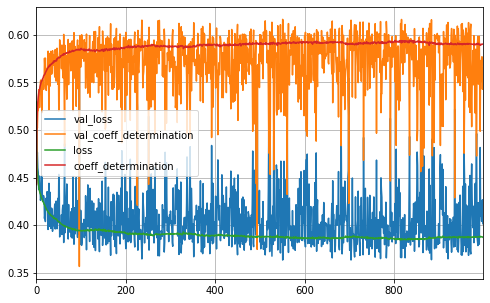

In [9]:
def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

def create_keras_model(activation='selu', optimizer='adam', neuron=50, init='lecun_normal'):
#     model_sequences = [
#         keras.layers.Dense(units=neuron, activation=activation, kernel_initializer=init, input_shape=x_train.shape[1:]),      
#     ]
    
#     for i in range(7):
#         model_sequences.append(keras.layers.Dense(units=neuron / (i+1), activation=activation, kernel_initializer=init, input_shape=x_train.shape[1:]))
#     model_sequences.append(keras.layers.BatchNormalization())
#     model_sequences.append(Dense(units=1, activation=activation, name='score_output'))
#     #model_sequences.append(keras.layers.Activation(activation))

#     nn_model = keras.models.Sequential(model_sequences)
    
    input_layer = Input(shape=x_train.shape[1:])
    layer = Dense(units=neuron,  kernel_initializer=init, input_shape=x_train.shape[1:])(input_layer)
    
    for i in range(5):
        layer = Dense(units=neuron, activation=activation, kernel_initializer=init)(layer)

    score_output = Dense(units=1, activation=activation, name='score_output')(layer)
    nn_model = Model(inputs=input_layer, outputs=[score_output])
    
    nn_model.compile(optimizer=optimizer, loss='mse', metrics=[coeff_determination])
    return nn_model

activation = LeakyReLU(alpha=0.3)
nn_model = create_keras_model(activation=activation, optimizer='Adadelta', neuron=100, init='lecun_uniform')
print("Keras model constructed")
history = nn_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1000, verbose=1)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.show()

# with open('../models/failure_predicting/sequential_1k_epoch.json') as f:
#     nn_model = model_from_json(f.read())
# optimizer = tensorflow.keras.optimizers.Adadelta(lr=1e-5)
# nn_model.load_weights('../models/failure_predicting/sequential_1k_epoch.h5')
# nn_model.compile(optimizer=optimizer, loss='mse', metrics=[coeff_determination])
# history = nn_model.fit(x_train, y_train, epochs=500, verbose=1)
# pd.DataFrame(history.history).plot(figsize=(8, 5))
# plt.grid(True)
# #plt.gca().set_ylim(0, 1)
# plt.show()

In [130]:
save_keras_model(nn_model, history, "sequential_15k_epoch")

model saved


In [7]:
nn_model = load_nn_model('sequential_15k_epoch')
nn_model

In [20]:
prepare_features(folder='test')

Done
